# Overview:
Our goal is to answer some basic questions about the movie industry and make recommendations based on our findings. 

First, we set out to learn a few basic things from our data- budgets, gross and net profit, which will inform our choices. 

Next, we examine various factors and look for correlations between them and profit. The factors we focused on most are genre, release date, run time and rating.

By isolating the factors that had the most positive correlation to profit, we are able to combine them and look for the most likely scenarios to generate returns, and how much to weigh each of our recommendations.

## Phase 1- 
Importing libraries and datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import requests
import sys
import time
from bs4 import BeautifulSoup

In [3]:
movie_gross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
name_basics = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
title_akas = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
title_basics = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
#on inspection, we didn't find the following datasets relevant to our hypotheses
#title_crew = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
#title_principals = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
title_ratings = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
movie_info= pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews= pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding='windows-1254')
budgets = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
#this last one was generated through web scraping- see the code in section 3 below
freshrating = pd.read_csv('./freshrating.csv')

## Phase 2-
### Data cleaning, ordering and merging the datasets

Working with the budgets dataset- the most complete of our sheets at a glance, but missing values are represented as 0, so on a closer look we had to drop a lot of incomplete rows.

In [4]:
#converting all values in budgets sheets to ints by removing commas and $
budgets['domestic_gross'] = budgets['domestic_gross'].astype(str)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$' , '')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',', '')
budgets['domestic_gross'] = budgets['domestic_gross'].astype(int)

budgets['production_budget'] = budgets['production_budget'].astype(str)
budgets['production_budget'] = budgets['production_budget'].str.replace('$' , '')
budgets['production_budget'] = budgets['production_budget'].str.replace(',', '')
budgets['production_budget'] = budgets['production_budget'].astype(int)

budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(str)
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$' , '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(',', '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(float)
#converting release dates to datetime format
budgets.release_date = pd.to_datetime(budgets['release_date'])
#creating new lines showing the difference between gross and cost, aka net, as well as a profit percentage calculation showing net over budget
budgets['domestic_net']= budgets['domestic_gross']- budgets['production_budget']
budgets['worldwide_net']= budgets['worldwide_gross']- budgets['production_budget']
budgets['profit_percentage'] = (budgets['worldwide_net']/budgets['production_budget'])*100

In [5]:
#The movies in the budget sheet start in 1915 and will definitely pull the spread of our dataset way down, particularly as we measure revenue
budgets.release_date.sort_values().unique()
#dropping all values of movies made before 1995- this excludes about 700 rows with dates from 1915-1995 and leaves 5000
budgets = budgets[~budgets['release_date'].isin(pd.date_range(start='1915-01-01', end='1995-12-31'))]
#renaming the title column in preparation for merge
budgets.rename(columns= {'movie': 'primary_title'}, inplace= True)

We merged the two IMDb sheets that seemed the most relevant to our questions, which allowed us to pull genre, rating and title information. 

In [6]:
#combining ratings and basics to produce a dataframe that matches titles to ratings
titlerate = title_ratings.merge(title_basics, on= 'tconst', how= 'outer')
#dropping null values from the combined table
titlerate.dropna(subset= ['averagerating'], inplace = True)
titlerate.dropna(subset = ['genres'], inplace = True)
#converting the genres column to lists
titlerate.genres = titlerate.genres.apply(lambda x: re.split(",",x) if isinstance(x,str) else x)
#iterating through the lists and seperating at commas, not sure why that didn't work above
for i in list(range(len(titlerate.genres))):
    try:
        if  type(titlerate.genres[i][0]) == str:
            titlerate.genres[i][0].split(',')
    except KeyError:
        i +=1
        continue

There are a lot of issues with the Rotten Tomatoes database- we tried using the code below to generate an index of 'freshness' based on assigning values of 1 or 0 to fresh and rotten, respectively, but in the end decided to scrape from the web. 

In [7]:
#aggregating reviews in the rt_reviews set by replacing 'fresh' and 'rotten' with 1 and 0 respectively, then generating an average and using it as a rating system
rt_reviews['fresh_index'] = rt_reviews['fresh'].replace('fresh', 1).replace('rotten', 0)
rt_reviews['fresh_average'] = rt_reviews.groupby(['id'])['fresh_index'].mean()
rt_reviews.dropna(subset= ['fresh_average'], inplace = True)
#adding the freshness average to the movie_info sheet, as the reviews one is about 50,000 lines long and has little useful data
movie_info['freshness'] = rt_reviews.fresh_average

The second Rotten Tomatoes dataset proved far more useful- since it includes revenue, dates, and genres. Unfortunately it does not include titles, which forced us to use it independently.

In [8]:
#changing the theater dates to datetime format so we can measure revenue against release date
movie_info['theater_date'] = pd.to_datetime(movie_info['theater_date'])
#dropping dates before 1995 in order to focus on relevant data
movie_info = movie_info[~movie_info['theater_date'].isin(pd.date_range(start='1915-01-01', end='1995-12-31'))]
#dropping the dvd date column to avoid confusion
movie_info.drop(['dvd_date'], axis = 1, inplace = True)
#reformatting the box office numbers to ints
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')

In [9]:
#since all currency seems to be in dollars we don't need to bother with a conversion here
movie_info.currency.unique()

array(['$', nan], dtype=object)

In [10]:
#splitting the genres in movie info
movie_info['genres']=movie_info.genre.apply(lambda x: re.split("and|\|",x) if isinstance(x,str) else x)
#dropping NAs from genres
movie_info.dropna(subset = ['genres'], inplace = True)

Finally, we merged the IMDb and budgets datasets to produce our most comprehensive sheet.

In [11]:
# merging the cleaned dataframes
maindf = budgets.merge(titlerate, on= 'primary_title', how= 'inner')

## Phase 3-
### Web Scraping

Because the Rotten Tomatoes datasets didn't include titles, we decided to scrape data from the internet and apply the ratings to the merged IMDb and budget tables- yeilding the most complete possible merge of the groups.

First, we generate a scraping function to pull the percentage numbers from each url.

In [12]:
#reformatting the title column to be inserted into a url
title_series = maindf.original_title.str.replace(' ', '_')
#the first function inserts a given title into a url and then pulls the freshness score from Rotten Tomatoes
def find_freshness(title):
    page = requests.get(f'http://rottentomatoes.com/m/{title}')
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup.find(class_= 'mop-ratings-wrap__percentage').text.strip()
#the second function uses the first as a helper by taking a list of titles, running them through find_freshness and updating a dictionary with titles and the ratings it returns
def fresh_list(titles):
    f = {}
    for i in titles:
        try:
            f.update({i : find_freshness(i)})
            time.sleep(np.random.randint(.01,1))
        except:
            AttributeError
            time.sleep(np.random.randint(.01, 1))
            continue
    return f 

Then we run the function and save the output to csv.

In [12]:
#this is commented out to avoid a long wait while the scrape function renders
#this is the function that created my freshrating dictionary which will be exported to csv
# fresh_scores = fresh_list(title_series)
#converting the returned dictionary to a series
# fresh_scores = pd.Series(fresh_scores)
#converting the titles back to the format in maindf
# fresh_scores.primary_title = test.primary_title.str.replace('_', ' ')
#saving as a csv file
# fresh_scores.to_csv('./freshrating.csv')

In [13]:
#now we can merge the datasets into a new df- though smaller, it's now the most comprehensive set 
df = maindf.merge(freshrating, on= 'primary_title', how = 'inner')
df.rating = df.rating.str.replace('%', '')
df.rating = df.rating.astype(int)

## Phase 4-  
### Visualizations and Examining the Datasets

#### Part 1: Ratings vs. Gross and Profit

Text(0.5, 1.0, 'Worldwide Gross by Rotten Tomatoes Rating')

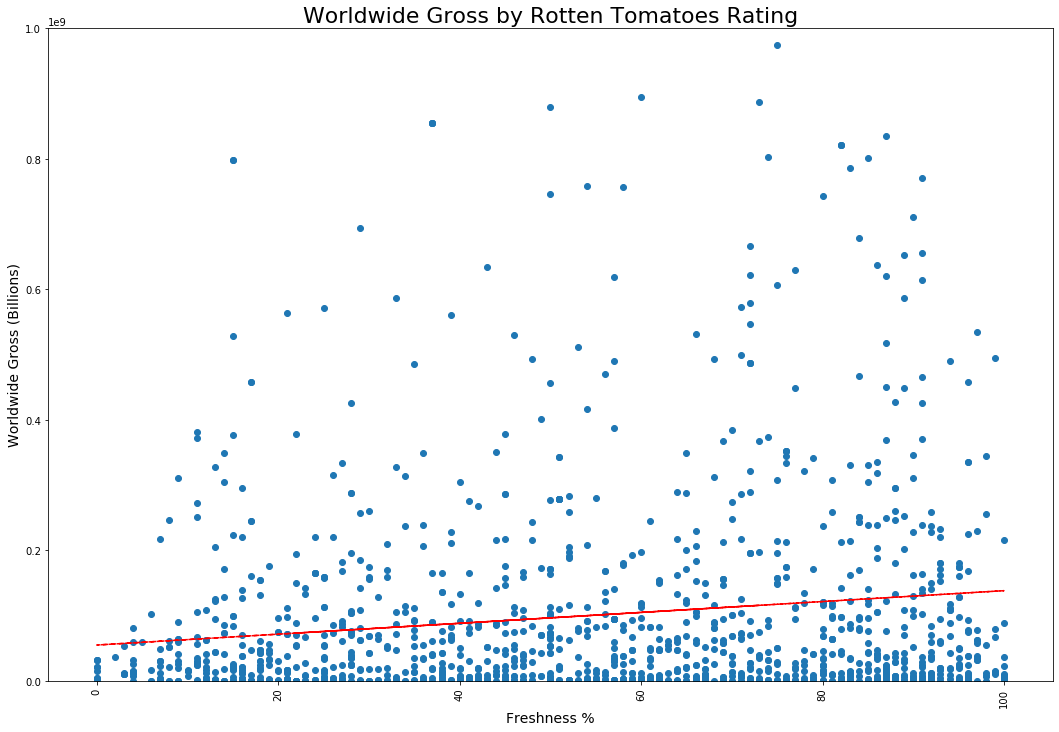

In [27]:
#there is a slight positive correlation between rating and gross
fig, ax = plt.subplots(figsize= (18, 12))
x= df.rating
y= df.worldwide_gross 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
ax.set_xlabel('Freshness %', fontsize=14)
ax.set_ylabel('Worldwide Gross (Billions)', fontsize= 14)
ax.set_ylim(0, 1000000000)
plt.xticks(rotation= 90)
plt.scatter(x, y)
ax.set_title('Worldwide Gross by Rotten Tomatoes Rating', fontsize= 22)

Text(0.5, 1.0, 'Return on Investment by Rotten Tomatoes Rating')

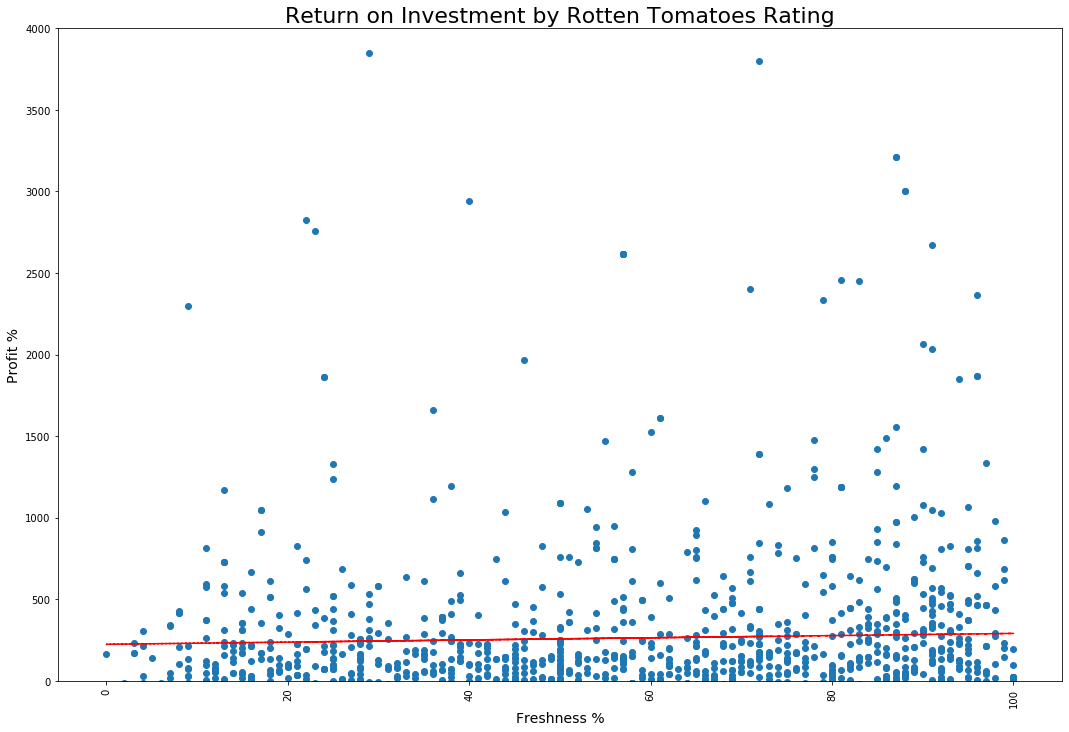

In [25]:
#profitability based on rating has a near zero correlation, on the other hand
fig, ax = plt.subplots(figsize= (18, 12))
x= df.rating
y= df.profit_percentage 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
ax.set_xlabel('Freshness %', fontsize= 14)
ax.set_ylabel('Profit %', fontsize= 14)
ax.set_ylim(0, 4000)
plt.xticks(rotation= 90)
plt.scatter(x, y)
ax.set_title('Return of Investment by Rotten Tomatoes Rating', fontsize=22)

In [16]:
df.corrwith(df.rating)

id                   0.003522
production_budget    0.021491
domestic_gross       0.136906
worldwide_gross      0.120613
domestic_net         0.171319
worldwide_net        0.137705
profit_percentage    0.014987
averagerating        0.457955
numvotes             0.226163
start_year           0.030103
runtime_minutes      0.165205
Unnamed: 0           0.031576
rating               1.000000
dtype: float64

#### Part 2: Release Date vs. Gross and Profit

Text(0.5, 1.0, 'Worldwide Gross by Release Date')

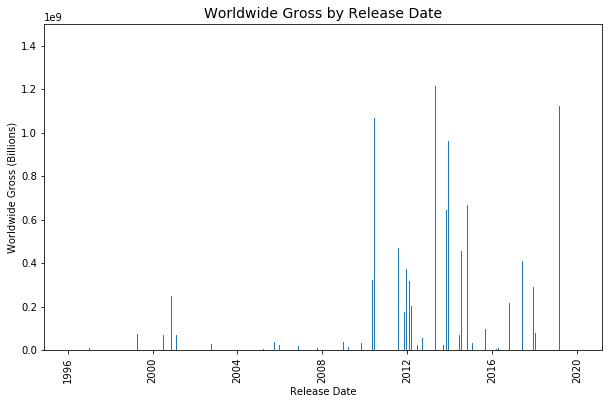

In [30]:
#plotting worldwide gross for our selected time period. There are some pretty obvious peaks and valleys, just need to get into the year over year and follow the trends. I cropped out the outlier data above $1.5bn to show more granular spread 
fig, ax = plt.subplots(figsize= (10, 6))
x= maindf['release_date']
y= maindf.worldwide_gross 

ax.set_xlabel('Release Date')
ax.set_ylabel('Worldwide Gross (Billions)')
ax.set_ylim(0, 1500000000)
plt.xticks(rotation= 90)
plt.bar(x, y)
ax.set_title('Worldwide Gross by Release Date', fontsize=14)

In [32]:
#calculating monthly average profit percentage to see which month is most profitable
maindf_monthnet = maindf.groupby(maindf['release_date'].dt.strftime('%m%B'))['profit_percentage'].mean().sort_index()

Text(0.5, 1.0, 'Return on Investment by Release Month')

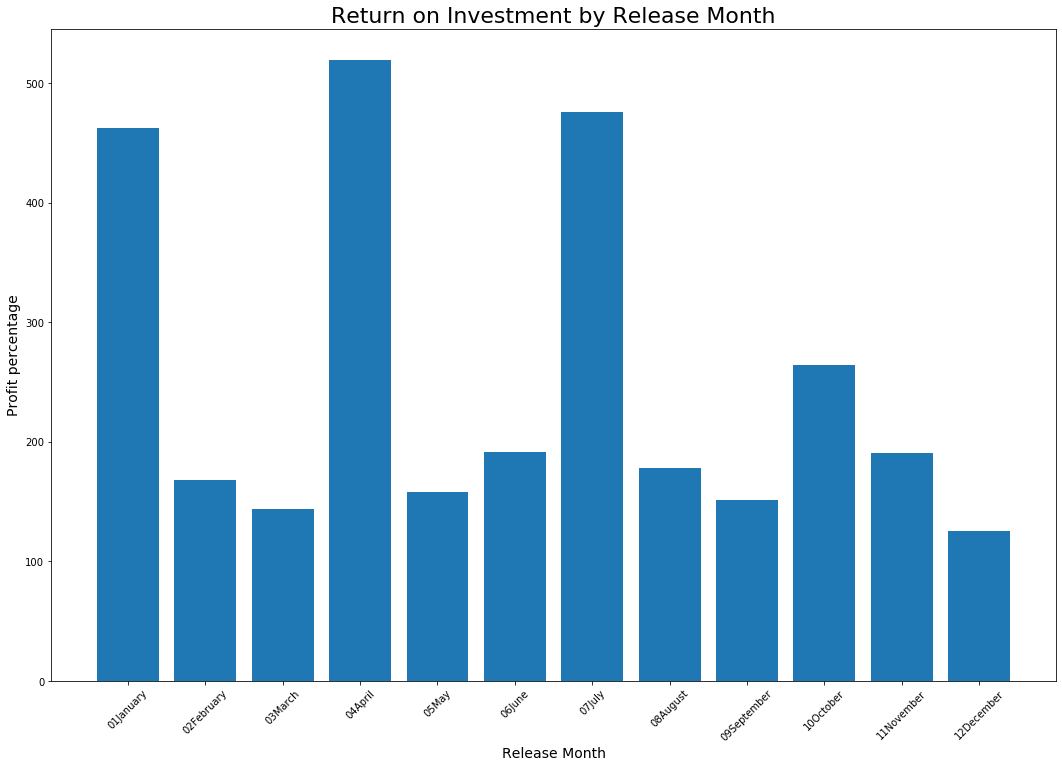

In [33]:
#Here we can see there are some definite peak months- we can conclude the best months to release films for profitability are January, April, July and October
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf_monthnet.keys()
y= maindf_monthnet

ax.set_xlabel('Release Month', fontsize = 14)
ax.set_ylabel('Profit percentage', fontsize = 14)
plt.xticks(rotation= 45)
plt.bar(x,y)
ax.set_title('Return of Investment by Release Month', fontsize=22)

#### Part 3: Runtime vs. Profit

Text(0.5, 1.0, 'Return on Investment by Runtime (minutes)')

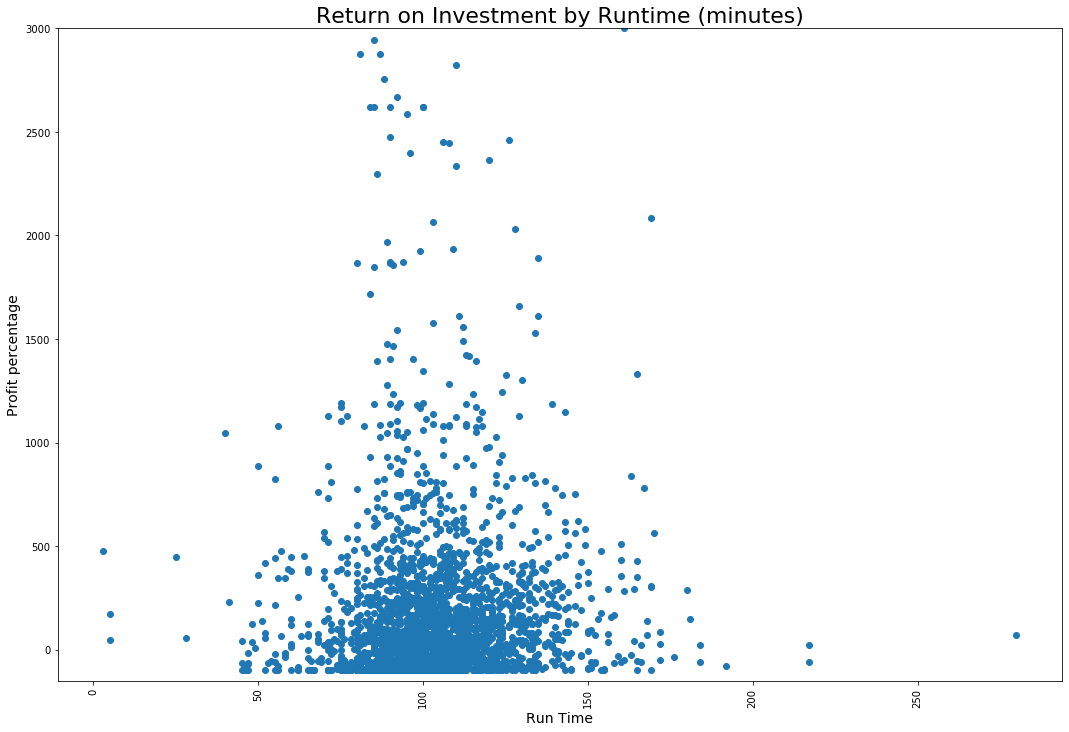

In [35]:
#plotting runtime vs profit percentage to see if there's an ideal movie length, overall looks like there's no correlation
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf['runtime_minutes']
y= maindf.profit_percentage
ax.set_xlabel('Run Time', fontsize = 14)
ax.set_ylabel('Profit percentage', fontsize = 14)
plt.xticks(rotation= 90)
ax.set_ylim(-150, 3000)
plt.scatter(x,y)
ax.set_title('Return of Investment by Runtime (minutes)', fontsize = 22)

In [22]:
maindf.corrwith(maindf['runtime_minutes'])

id                  -0.038877
production_budget    0.253305
domestic_gross       0.196927
worldwide_gross      0.211170
domestic_net         0.046943
worldwide_net        0.183077
profit_percentage   -0.014817
averagerating        0.225979
numvotes             0.372349
start_year           0.070643
runtime_minutes      1.000000
dtype: float64

#### Part 4: Budget vs. Profit

In [23]:
#here we see there is no correlation between initial production budget and profitability, but there are a lot of outliers in our dataset. As mentioned above, the budgets sheet contained a lot of zero values as placeholders, so we worked on a succession of graphs to show the removal of outlier data.
maindf.corrwith(maindf['production_budget'])

id                  -0.043503
production_budget    1.000000
domestic_gross       0.732088
worldwide_gross      0.786046
domestic_net         0.126647
worldwide_net        0.665985
profit_percentage   -0.031227
averagerating        0.135606
numvotes             0.505046
start_year           0.034041
runtime_minutes      0.253305
dtype: float64

Text(0.5, 1.0, 'Return of Investment by Production Budget')

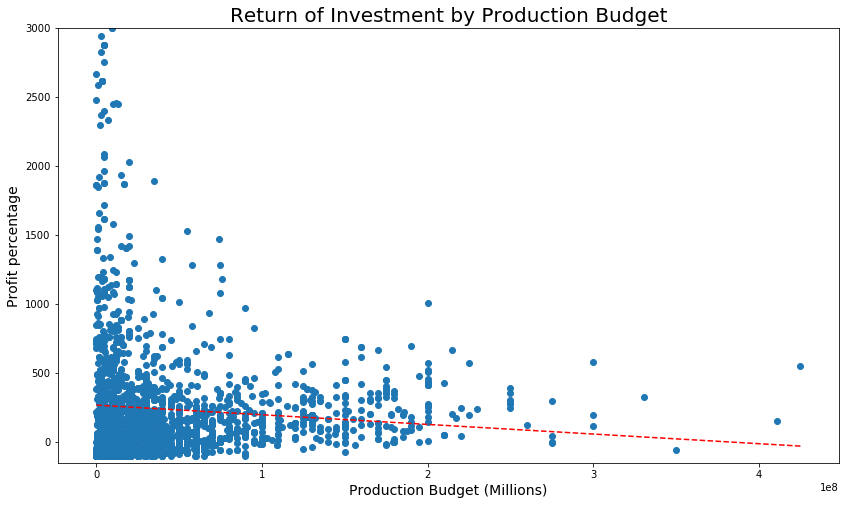

In [36]:
#plotting production budget vs. profit percentage to find ideal sweet spot of budget spent vs profit returned
fig, ax = plt.subplots(figsize= (14, 8))
x= maindf['production_budget']
y= maindf.profit_percentage
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
ax.set_xlabel('Production Budget (Millions)', fontsize = 14)
ax.set_ylabel('Profit percentage', fontsize = 14)
ax.set_ylim(-150, 3000)
plt.scatter(x,y)
ax.set_title('Return of Investment by Production Budget', fontsize = 20)
#let's clean up the outlier data here and see if there's a clearer picture

In [38]:
#creating copies of our maindf cleared out outlier data and with ~70% of central weighted data for the budget column
maindf_1 = pd.DataFrame(maindf)
maindf_1['production_budget'] = maindf_1['production_budget'].sort_values()[150:2500]
maindf_1.dropna(subset= ['production_budget'], inplace = True)

maindf_2 = pd.DataFrame(maindf)
maindf_2['production_budget'] = maindf_2['production_budget'].sort_values()[600:2100]
maindf_2.dropna(subset = ['production_budget'], inplace = True)

By clearing the outlier data successively we see the trend line flattening. Our conclusion is that by spending less than $50 million in initial budget, you signigicantly reduce the likelihood of running a loss percentage.

Text(0, 0.5, 'Profit percentage')

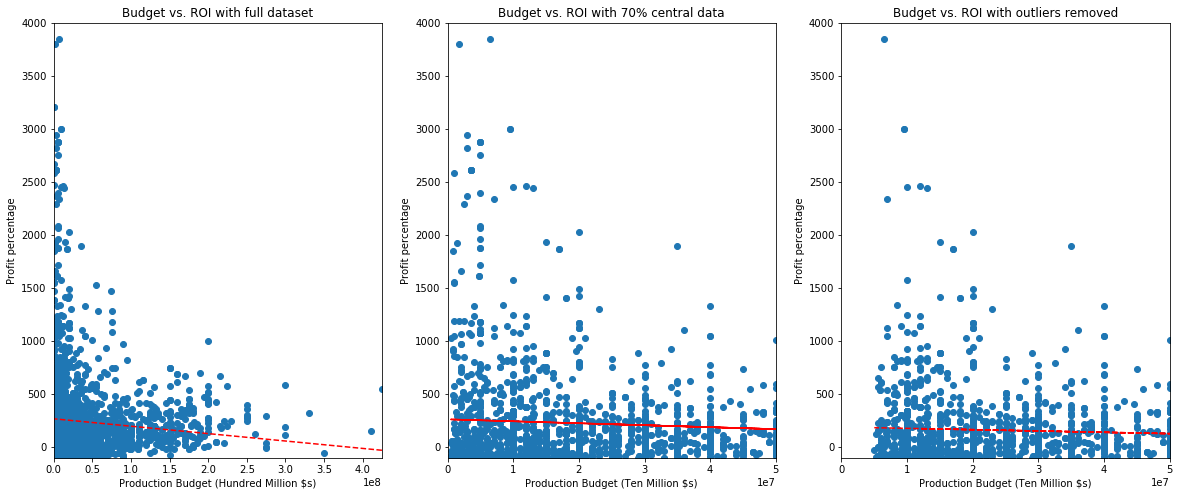

In [40]:
budget_fig = plt.figure(figsize= (20, 8))

ax = budget_fig.add_subplot(131)
ax1 = budget_fig.add_subplot(132)
ax2 = budget_fig.add_subplot(133)

z = np.polyfit(maindf.production_budget, maindf.profit_percentage, 1)
z1= np.polyfit(maindf_1.production_budget, maindf_1.profit_percentage, 1)
z2= np.polyfit(maindf_2.production_budget, maindf_2.profit_percentage, 1)
p = np.poly1d(z)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)

ax.scatter(maindf.production_budget, maindf.profit_percentage)
ax.plot(maindf.production_budget, p(maindf.production_budget),"r--")

ax1.scatter(maindf_1.production_budget, maindf_1.profit_percentage)
ax1.plot(maindf_1.production_budget, p1(maindf_1.production_budget),"r--")

ax2.scatter(maindf_2.production_budget, maindf_2.profit_percentage)
ax2.plot(maindf_2.production_budget, p2(maindf_2.production_budget),"r--")

ax.set_ylim(-100, 4000)
ax1.set_ylim(-100, 4000)
ax2.set_ylim(-100, 4000)
ax.set_xlim(0, 425000000)
ax1.set_xlim(0, 50000000)
ax2.set_xlim(0, 50000000)

ax.set_title('Budget vs. ROI with full dataset')
ax2.set_title('Budget vs. ROI with outliers removed')
ax1.set_title('Budget vs. ROI with 70% central data')

ax.set_xlabel('Production Budget (Hundred Million $s)')
ax.set_ylabel('Profit percentage')
ax1.set_xlabel('Production Budget (Ten Million $s)')
ax1.set_ylabel('Profit percentage')
ax2.set_xlabel('Production Budget (Ten Million $s)')
ax2.set_ylabel('Profit percentage')

#### Part 5- Genre vs. Profit

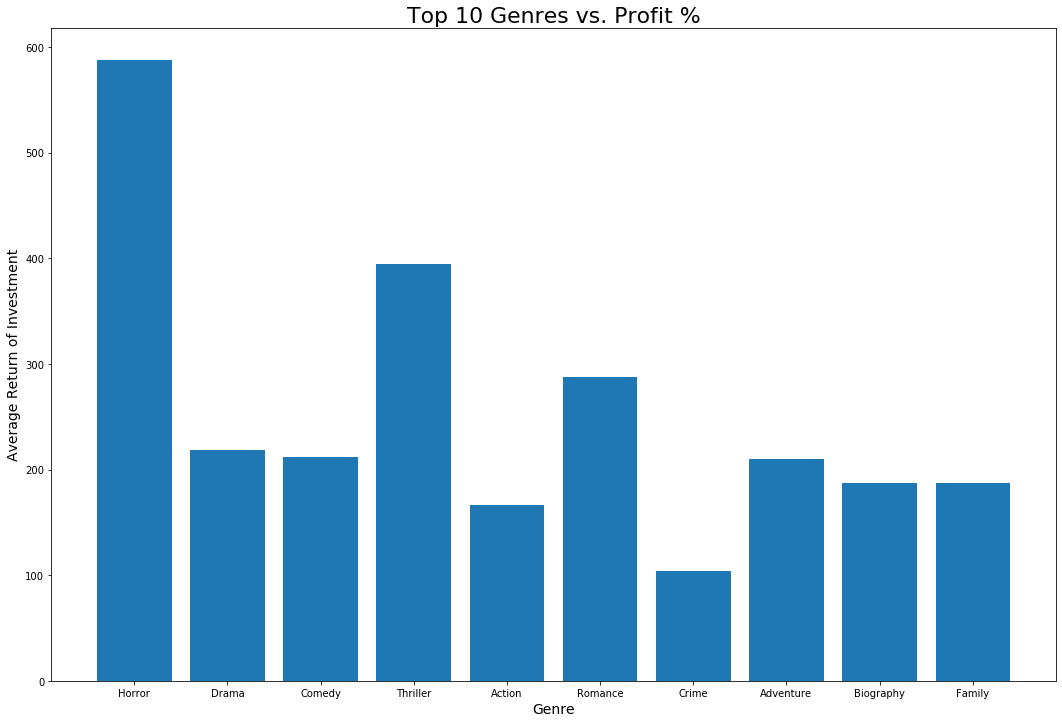

In [45]:
#Creating new column as a 'Genre Indicator and calculating avg mean profit % and ratings'
maindf['isHorror'] = maindf['genres'].apply(lambda x: "Horror" in x).astype(int)
maindf['isDrama'] = maindf['genres'].apply(lambda x: "Drama" in x).astype(int)
maindf['isComedy'] = maindf['genres'].apply(lambda x: "Comedy" in x).astype(int)
maindf['isThriller'] = maindf['genres'].apply(lambda x: "Thriller" in x).astype(int)
maindf['isAction'] = maindf['genres'].apply(lambda x: "Action" in x).astype(int)
maindf['isRomance'] = maindf['genres'].apply(lambda x: "Romance" in x).astype(int)
maindf['isCrime'] = maindf['genres'].apply(lambda x: "Crime" in x).astype(int)
maindf['isAdventure'] = maindf['genres'].apply(lambda x: "Adventure" in x).astype(int)
maindf['isBiography'] = maindf['genres'].apply(lambda x: "Biography" in x).astype(int)
maindf['isFamily'] = maindf['genres'].apply(lambda x: "Biography" in x).astype(int)
maindf_horror = maindf[maindf['isHorror']!=0]
maindf_drama = maindf[maindf['isDrama']!=0]
maindf_comedy = maindf[maindf['isComedy']!=0]
maindf_thriller = maindf[maindf['isThriller']!=0]
maindf_action = maindf[maindf['isAction']!=0]
maindf_romance = maindf[maindf['isRomance']!=0]
maindf_crime = maindf[maindf['isCrime']!=0]
maindf_adventure = maindf[maindf['isAdventure']!=0]
maindf_biography = maindf[maindf['isBiography']!=0]
maindf_family = maindf[maindf['isFamily']!=0]
horror_profitavg = (maindf_horror['profit_percentage'].mean())
drama_profitavg = (maindf_drama['profit_percentage'].mean())
comedy_profitavg = (maindf_comedy['profit_percentage'].mean())
thriller_profitavg = (maindf_thriller['profit_percentage'].mean())
action_profitavg = maindf_action['profit_percentage'].mean()
romance_profitavg = maindf_romance['profit_percentage'].mean()
crime_profitavg = maindf_crime['profit_percentage'].mean()
adventure_profitavg = maindf_adventure['profit_percentage'].mean()
biography_profitavg = maindf_biography['profit_percentage'].mean()
family_profitavg = maindf_family['profit_percentage'].mean()
horror_ratingavg = (maindf_horror['averagerating'].mean())
drama_ratingavg = (maindf_drama['averagerating'].mean())
comedy_ratingavg = (maindf_comedy['averagerating'].mean())
thriller_ratingavg = (maindf_thriller['averagerating'].mean())
action_ratingavg = maindf_action['averagerating'].mean()
romance_ratingavg = maindf_romance['averagerating'].mean()
crime_ratingavg = maindf_crime['averagerating'].mean()
adventure_ratingavg = maindf_adventure['averagerating'].mean()
biography_ratingavg = maindf_biography['averagerating'].mean()
family_ratingavg = maindf_family['averagerating'].mean()

#Charting Genre vs. Profit % to see which Genre is most profitable
X = ['Horror','Drama','Comedy','Thriller','Action','Romance','Crime','Adventure','Biography','Family']
Y = [horror_profitavg,drama_profitavg,comedy_profitavg,thriller_profitavg,action_profitavg,romance_profitavg,crime_profitavg,adventure_profitavg,biography_profitavg,family_profitavg]
fig, ax = plt.subplots(figsize=(18,12))
plt.bar(X, Y)
ax.set_title("Top 10 Genres vs. Profit %", fontsize=22) 
ax.set_xlabel('Genre', fontsize = 14)
ax.set_ylabel('Average Return of Investment', fontsize = 14)
plt.show()

Since Horror seems to be by far the most profitable, followed by Thriller, we have some pretty solid conclusions about what kinds of movies to produce.

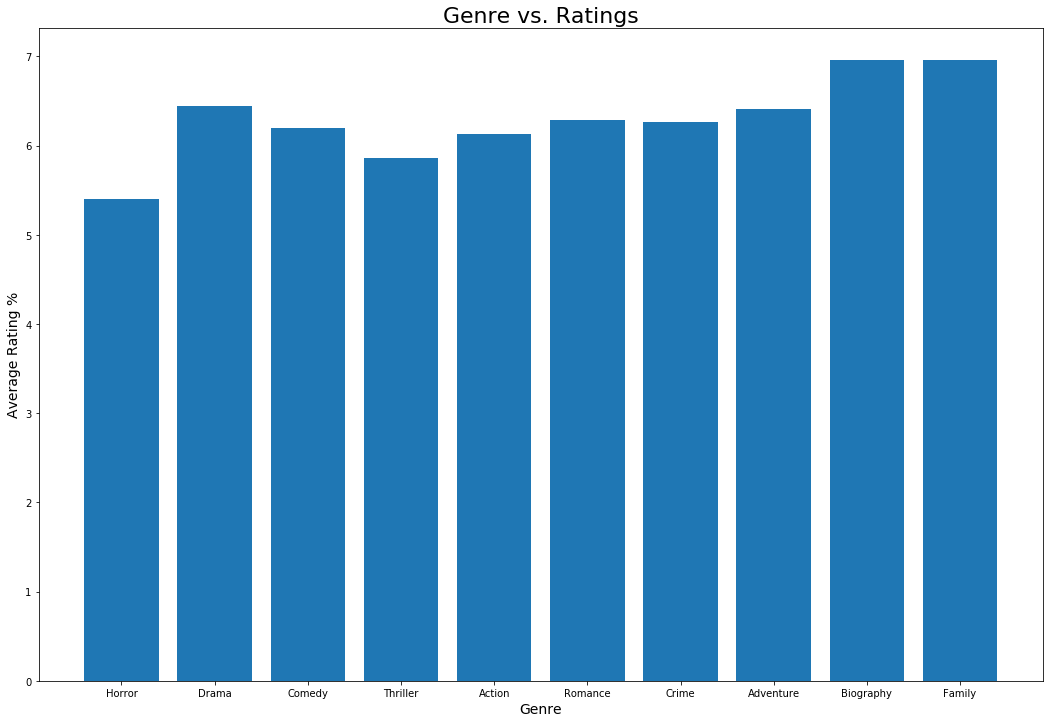

In [46]:
#Charting Genre vs. Rating to see which Genre receives highest ratings
X = ['Horror','Drama','Comedy','Thriller','Action','Romance','Crime','Adventure','Biography','Family']
Y = [horror_ratingavg,drama_ratingavg,comedy_ratingavg,thriller_ratingavg,action_ratingavg,romance_ratingavg,crime_ratingavg,adventure_ratingavg,biography_ratingavg,family_ratingavg]
fig, ax = plt.subplots(figsize=(18,12))
plt.bar(X, Y)
ax.set_title("Genre vs. Ratings", fontsize = 22) 
ax.set_xlabel('Genre', fontsize = 14)
ax.set_ylabel('Average Rating %', fontsize = 14)
plt.show()

Horror does seem to generate the lowest average ratings of all the genres we inspected, but because our correlation between ratings and profit is so small, we consider the ratings far less important.

## Phase 5-
### Conclusion

Based on the visualizations and calculations above, we've concluded that the best strategy to making profitable movies is to create horror or thriller titles with a budget ranging from 5mil to 50mil and a release schedule of every three months- January, April, July and October.

We look forward to seeing a variety of new horror titles from Microsoft. 